# Grad-TTS: A Diffusion Probabilistic Model for Text-to-Speech

Official implementation of the Grad-TTS model based on Diffusion Probabilistic Models. For all details check out our paper accepted to ICML 2021 via [this](https://arxiv.org/abs/2105.06337) link.

You can listen to the samples on our demo page via [this](https://grad-tts.github.io/) link.

You can access Google Colab demo notebook via [this](https://colab.research.google.com/drive/1YNrXtkJQKcYDmIYJeyX8s5eXxB4zgpZI?usp=sharing) link.

**Authors**: Vadim Popov\*, Ivan Vovk\*, Vladimir Gogoryan, Tasnima Sadekova, Mikhail Kudinov.

<sup>\*Equal contribution.</sup>

**Note**: for fast synthesis prefer running inference on GPU device.

In [1]:
import torch

print("Pytorch version：")
print(torch.__version__)
print("CUDA Version: ")
print(torch.version.cuda)
print("cuDNN version is :")
print(torch.backends.cudnn.version())

import sys
sys.path
%pip install -r requirements.txt
#%pip install tensorboard
#%pip install setuptools==59.5.0
# %pip install librosa==0.8.0
# print("yy")
# from torch.utils.tensorboard import SummaryWriter

Pytorch version：
1.9.0+cu111
CUDA Version: 
11.1
cuDNN version is :
8005


c:\Users\Aubin\Desktop\Proj DL\Grad-TTS\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note: you may need to restart the kernel to use updated packages.


In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
import argparse
import json
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from scipy.io.wavfile import write

# For Grad-TTS
import params
from model import GradTTS
from text import text_to_sequence, cmudict
from text.symbols import symbols
from utils import intersperse

# For HiFi-GAN
import sys
sys.path.append('./hifi-gan/')
from env import AttrDict
from models import Generator as HiFiGAN

In [4]:
N_SPKS = 6  # 247 for Libri-TTS model and 1 for single speaker (LJSpeech)
N_EMOS = 5 #Angry, Happy, Sad, Surprised, Neutral

In [48]:
generator = GradTTS(len(symbols)+1, N_SPKS, params.spk_emb_dim,
                    params.n_enc_channels, params.filter_channels,
                    params.filter_channels_dp, params.n_heads, params.n_enc_layers,
                    params.enc_kernel, params.enc_dropout, params.window_size,
                    params.n_feats, params.dec_dim, params.beta_min, params.beta_max,
                    pe_scale=1000)  # pe_scale=1 for `grad-tts-old.pt`
#generator.load_state_dict(torch.load('./checkpts/grad-tts-libri-tts.pt', map_location=lambda loc, storage: loc))
generator.load_state_dict(torch.load('./checkpts/grad_10.pt', map_location=lambda loc, storage: loc))
_ = generator.cuda().eval()
print(f'Number of parameters: {generator.nparams}')

cmu = cmudict.CMUDict('./resources/cmu_dictionary')

Number of parameters: 14873256


In [49]:
with open('./checkpts/hifigan-config.json') as f:
    h = AttrDict(json.load(f))
hifigan = HiFiGAN(h)
hifigan.load_state_dict(torch.load('./checkpts/hifigan.pt', map_location=lambda loc, storage: loc)['generator'])
_ = hifigan.cuda().eval()
hifigan.remove_weight_norm()
%matplotlib inline

Removing weight norm...


In [50]:
text = "Hey you! You are doing a wonderful job!"

In [51]:
x = torch.LongTensor(intersperse(text_to_sequence(text, dictionary=cmu), len(symbols))).cuda()[None]
x_lengths = torch.LongTensor([x.shape[-1]]).cuda()
x.shape, x_lengths

(torch.Size([1, 69]), tensor([69], device='cuda:0'))

Grad-TTS RTF: 0.4515517228618421


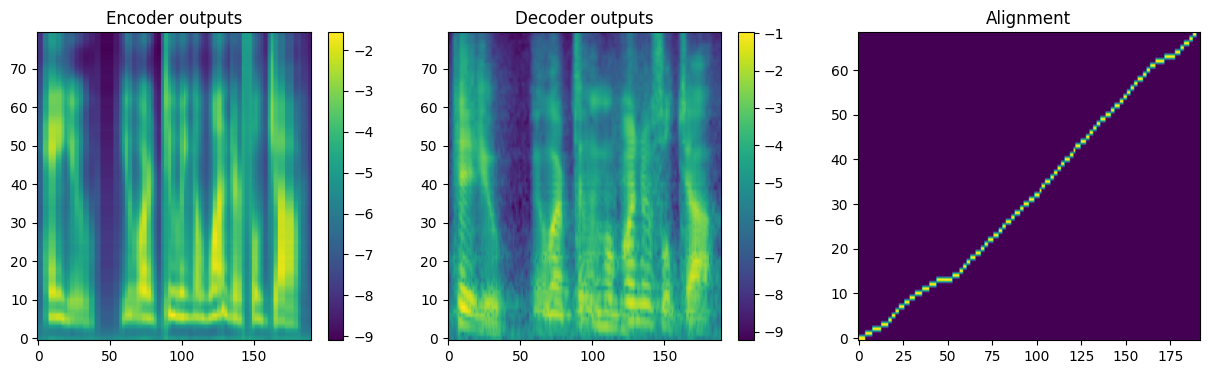

In [52]:
t = dt.datetime.now()
y_enc, y_dec, attn = generator.forward(x, x_lengths, n_timesteps=50, temperature=1.3,
                                       stoc=False, spk=None if N_SPKS==1 else torch.LongTensor([3]).cuda(),
                                       length_scale=0.91)
t = (dt.datetime.now() - t).total_seconds()
print(f'Grad-TTS RTF: {t * 22050 / (y_dec.shape[-1] * 256)}')

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title('Encoder outputs')
plt.imshow(y_enc.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title('Decoder outputs')
plt.imshow(y_dec.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title('Alignment')
plt.imshow(attn.cpu().squeeze(), aspect='auto', origin='lower');

In [53]:
import torch
import soundfile as sf

def export_audio_to_mp3(audio, sample_rate, output_filename):
    """
    Export audio data as an MP3 file.

    Args:
    audio (torch.Tensor): The audio data.
    sample_rate (int): The sample rate of the audio data.
    output_filename (str): The name of the output MP3 file.
    """
    audio = audio.cpu().squeeze().clamp(-1, 1)
    audio = audio.numpy()
    sf.write(output_filename, audio, sample_rate)
    print(f"MP3 audio saved to: {output_filename}")

# Example usage:
with torch.no_grad():
    audio = hifigan.forward(y_dec)
export_audio_to_mp3(audio, sample_rate=22050, output_filename="come_on_exbcp.mp3")

MP3 audio saved to: come_on_exbcp.mp3


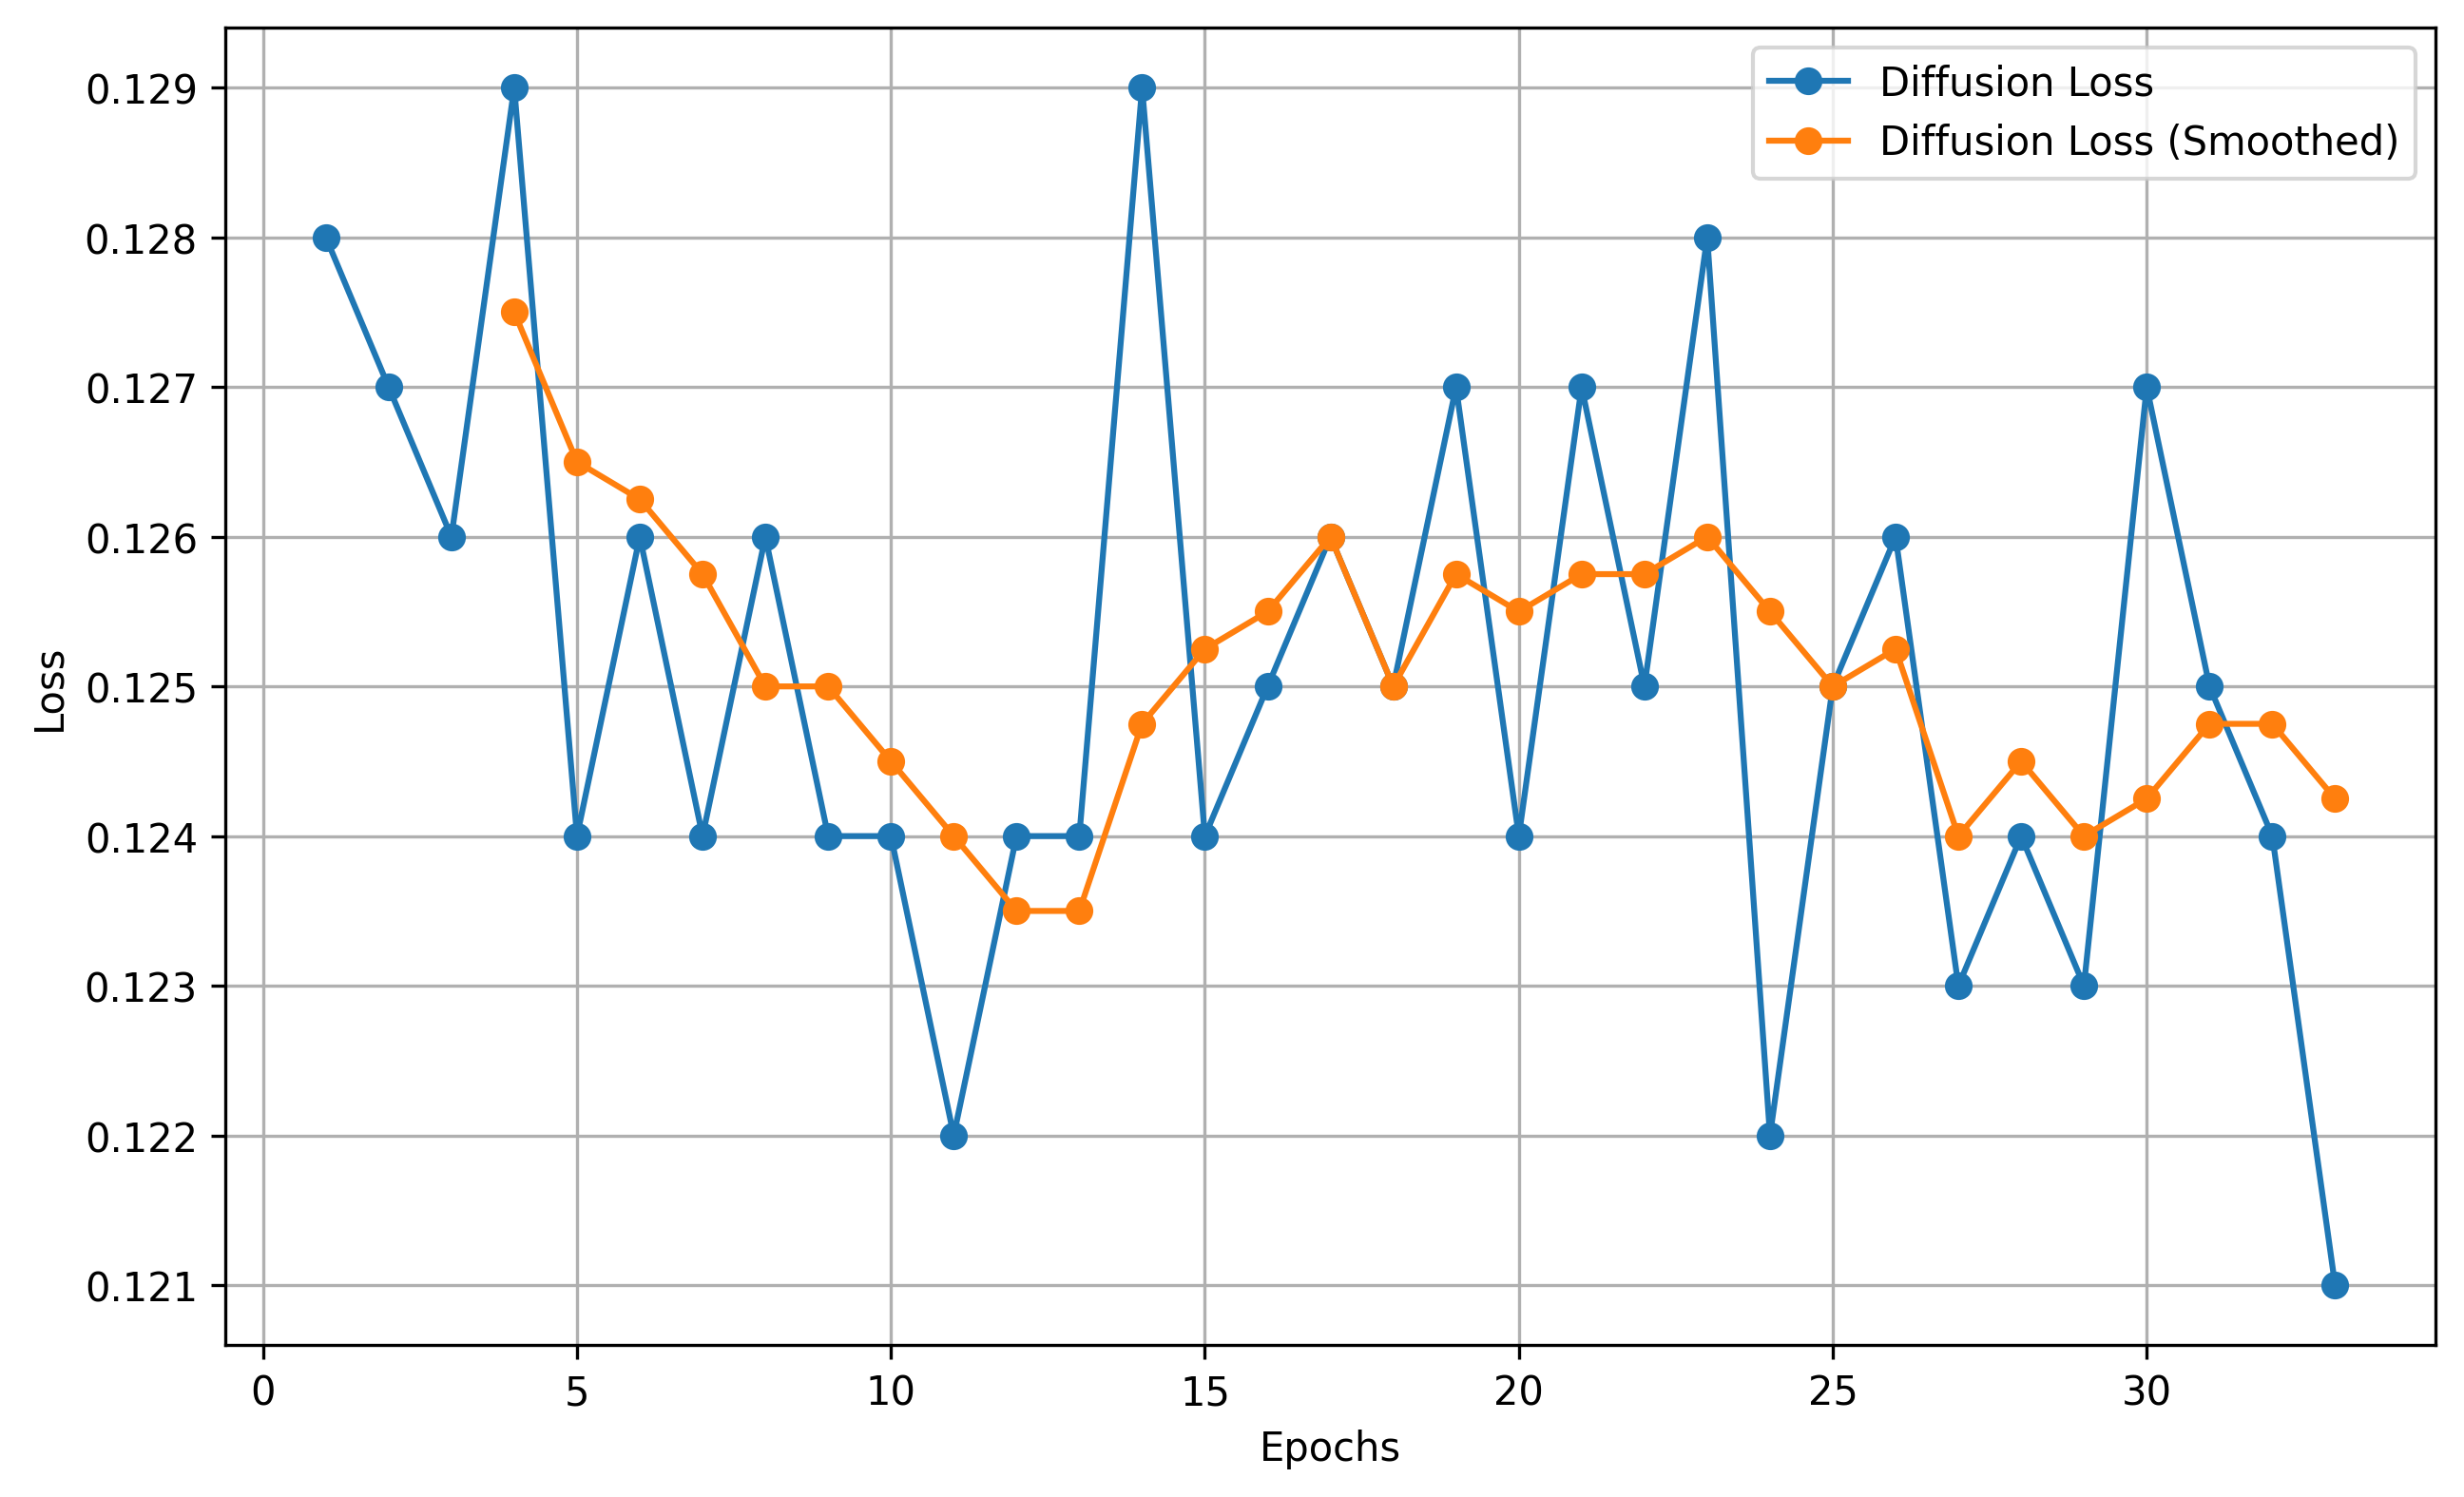

In [ ]:
import matplotlib.pyplot as plt
import csv# Define the data
epochs = list(range(1, 34))
duration_loss = [1.824, 1.822, 1.824, 1.826, 1.824, 1.821, 1.823, 1.824, 1.823, 1.826, 1.823, 1.824, 1.825, 1.822, 1.820, 1.825, 1.823, 1.827, 1.822, 1.824, 1.823, 1.824, 1.826, 1.827, 1.828, 1.824, 1.824, 1.824, 1.824, 1.823, 1.822, 1.824, 1.825]
prior_loss = [1.541, 1.542, 1.541, 1.541, 1.541, 1.540, 1.541, 1.541, 1.538, 1.542, 1.543, 1.542, 1.541, 1.540, 1.540, 1.542, 1.542, 1.541, 1.541, 1.541, 1.540, 1.539, 1.541, 1.540, 1.542, 1.541, 1.541, 1.540, 1.540, 1.541, 1.542, 1.542, 1.540]
diffusion_loss = [0.128, 0.127, 0.126, 0.129, 0.124, 0.126, 0.124, 0.126, 0.124, 0.124, 0.122, 0.124, 0.124, 0.129, 0.124, 0.125, 0.126, 0.125, 0.127, 0.124, 0.127, 0.125, 0.128, 0.122, 0.125, 0.126, 0.123, 0.124, 0.123, 0.127, 0.125, 0.124, 0.121]

plt.figure(figsize=(10, 6),dpi=300)
#plt.plot(epochs, duration_loss, label='Duration Loss', marker='o')
#plt.plot(epochs, prior_loss, label='Prior Loss', marker='o')
plt.plot(epochs, diffusion_loss, label='Diffusion Loss', marker='o')
window_size = 4
diffusion_loss_smoothed = np.convolve(diffusion_loss, np.ones(window_size)/window_size, mode='valid')
plt.plot(epochs[window_size - 1:], diffusion_loss_smoothed, label='Diffusion Loss (Smoothed)', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Create a list of lists for the data
data = [['Epochs', 'Diffusion Loss', 'Diffusion Loss (Smoothed)']]
for i in range(len(epochs) - window_size + 1):
    data.append([epochs[i + window_size - 1], diffusion_loss[i + window_size - 1], diffusion_loss_smoothed[i]])

# Write the data to a CSV file
with open('loss_data.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerows(data)

In [ ]:
def compute_snr(original_audio, generated_audio):
    # Ensure both audio arrays have the same length
    min_length = min(len(original_audio), len(generated_audio))
    original_audio = original_audio[:min_length]
    generated_audio = generated_audio[:min_length]

    # Compute the power of the original and noise (original - generated)
    power_original = np.sum(original_audio ** 2)
    power_noise = np.sum((original_audio - generated_audio) ** 2)

    # Calculate SNR in dB
    snr = 10 * np.log10(power_original / power_noise)
    mse = np.mean((original_audio - generated_audio) ** 2)
    rmse = np.sqrt(mse)
    psnr = 10 * np.log10(1.0 / mse)
    return snr,mse,rmse,psnr

In [ ]:
import os
dataset_info_path = "../DL-TTS/Dataset/S07/dataset_S07.json"
inference_save_path = "../DL-TTS/Dataset/S07/Inferences/"


with open(dataset_info_path, 'r', encoding='utf-8') as json_file:
    dataset_info = json.load(json_file)

for entry in dataset_info:
    if "E01" in entry["path-wav"]:
        script = entry["text"]

        x = torch.LongTensor(intersperse(text_to_sequence(script, dictionary=cmu), len(symbols))).cuda()[None]
        x_lengths = torch.LongTensor([x.shape[-1]]).cuda()
        print("Generating speech for : \n"+script+"\n")

        y_enc, y_dec, attn = generator.forward(x, x_lengths, n_timesteps=50, temperature=1.3,
                                       stoc=False, spk=None if N_SPKS==1 else torch.LongTensor([15]).cuda(),
                                       length_scale=0.91)
        
        path_to_save_audio = inference_save_path+entry["path-wav"]
        with torch.no_grad():
            audio = hifigan.forward(y_dec)
        export_audio_to_mp3(audio, sample_rate=22050, output_filename=str(path_to_save_audio))

        if not os.path.exists(os.path.dirname(path_to_save_audio)):
            os.makedirs(os.path.dirname(path_to_save_audio))

Generating speech for : 
Hey, what's going on?

MP3 audio saved to: ../DL-TTS/Dataset/S07/Inferences/Clips/S07/E01/S07E01_000000.wav
Generating speech for : 
I found a note on my door, "Come to Monica's.

MP3 audio saved to: ../DL-TTS/Dataset/S07/Inferences/Clips/S07/E01/S07E01_000001.wav
Generating speech for : 
Bring champagne and a Three Musketeers bar"?

MP3 audio saved to: ../DL-TTS/Dataset/S07/Inferences/Clips/S07/E01/S07E01_000002.wav
Generating speech for : 
Yeah, I'll take that.

MP3 audio saved to: ../DL-TTS/Dataset/S07/Inferences/Clips/S07/E01/S07E01_000003.wav
Generating speech for : 
What's up?

MP3 audio saved to: ../DL-TTS/Dataset/S07/Inferences/Clips/S07/E01/S07E01_000004.wav
Generating speech for : 
- Monica and I are engaged. - Oh, my God.

MP3 audio saved to: ../DL-TTS/Dataset/S07/Inferences/Clips/S07/E01/S07E01_000005.wav
Generating speech for : 
Congratulations. Where is she?

MP3 audio saved to: ../DL-TTS/Dataset/S07/Inferences/Clips/S07/E01/S07E01_000006.wav
Gene